In [1]:
import os
import time
import numpy as np
from numpy import dstack
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.io import arff, loadmat
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Data Load
### 전처리 width, height, input_channel 정의

#### Load Multivariate Time Series Data

In [2]:
from load_data import load_data,class_breakdown

In [3]:
# fnames = ['ArabicDigits','CMUsubject16','ECG','JapaneseVowels','KickVsPunch', 'Libras','Outflow','UWave','Wafer','WalkVsRun']
fnames = ['Libras','UWave']

In [4]:
fname = fnames[1]
data_path = './data/'+fname
mat = loadmat(data_path+'/'+fname+'.mat') 
print('Load '+fname+' dataset')

Load UWave dataset


In [5]:
data_name = fname

In [6]:
data_name

'UWave'

In [7]:
trainx = mat['mts']['train']
trainy = mat['mts']['trainlabels']
testx = mat['mts']['test']
testy = mat['mts']['testlabels']

nb_trains = trainx[0][0].shape[1]
nb_tests = testx[0][0].shape[1]
nb_classes = trainy[0][0][-1][0]
print('nb_trains:',nb_trains,'\tnb_tests:',nb_tests, '\tnb_classes:', nb_classes)
nb_features = trainx[0][0][0][0].shape[0]
length = trainx[0][0][0][0].shape[1]
print('nb_features:',nb_features, '\tlength:', length)

nb_trains: 200 	nb_tests: 4278 	nb_classes: 1
nb_features: 3 	length: 315


#### make (nb_trains, length, nb_features)
Libras와 UWave를 제외한 나머지 데이터들은 length가 유동적이여서 현재 모델 입력에 적당하지 않음
따라서 Libras와 UWave 데이터만 일단 사용

In [8]:
def reshaping(X, Y):
    X = X[0][0][0]
    reshapedX = []
    for i in range(len(X)):
        reshapedX.append(X[i])
    reshapedX = np.array(reshapedX, dtype=np.float64)
    X = reshapedX.reshape(reshapedX.shape[0], reshapedX.shape[2], reshapedX.shape[1])
    
    Y = Y[0][0]
    reshapedY = []
    for i in range(len(Y)):
        reshapedY.append(Y[i][0])

    reshapedY = np.array(reshapedY, dtype=np.int64)
    trainy = reshapedY.reshape(reshapedY.shape[0], 1)
    
    return X, Y    

In [9]:
trainx, trainy = reshaping(trainx, trainy)

In [10]:
testx, testy = reshaping(testx, testy)

In [11]:
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

batch size:16
(200, 315, 3) (200, 1)
(4278, 315, 3) (4278, 1)


트레인+테스트 합치고, 트레인을 7:3으로나눠서 7을 실제 train에, 3을 실제 valid로 사용한 후의 결과들 저장

loss,acc graph보면서 러닝레이트 조절

In [20]:
dataX = np.vstack([trainx, testx])
dataY = np.vstack([trainy, testy])
trainx, testx, trainy, testy = train_test_split(dataX, dataY, test_size=0.3, random_state=42)

In [25]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=399, percentage=12.731
Class=2, total=379, percentage=12.093
Class=3, total=380, percentage=12.125
Class=4, total=401, percentage=12.795
Class=5, total=382, percentage=12.189
Class=6, total=398, percentage=12.699
Class=7, total=406, percentage=12.955
Class=8, total=389, percentage=12.412
Class=1, total=160, percentage=11.905
Class=2, total=181, percentage=13.467
Class=3, total=180, percentage=13.393
Class=4, total=159, percentage=11.830
Class=5, total=178, percentage=13.244
Class=6, total=162, percentage=12.054
Class=7, total=153, percentage=11.384
Class=8, total=171, percentage=12.723


In [26]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (3134, 8)
y test shape: (1344, 8)


In [27]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train
validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]
testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]
print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(3134, 1, 315, 3)
trainY shape:(3134, 8)
validX shape:(672, 1, 315, 3)
validY shape:(672, 8)
testX shape:(672, 1, 315, 3)
testY shape:(672, 8)


In [28]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]
print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 315
input_channel 3


### Training condition

In [29]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [30]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

### model structure

In [31]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff,CNN_MC_dropout_input_turnoff
import tensorflow as tf

In [32]:
class basic_CNN:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.prediction,1),tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 64, [1,8], padding='SAME')
            self.pooling1 = tf.layers.max_pooling2d(inputs=self.conv1, pool_size=[1, 4],padding="VALID", strides=2)
            self.batch1 = tf.layers.batch_normalization(self.pooling1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 128, [1,5], padding='SAME')
            self.pooling2 = tf.layers.max_pooling2d(inputs=self.conv2, pool_size=[1, 4] ,padding="VALID", strides=2)                                        
            self.batch2 = tf.layers.batch_normalization(self.pooling2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 256, [1,3], padding='SAME')
            self.pooling3 = tf.layers.max_pooling2d(inputs=self.conv3, pool_size=[1, 4] ,padding="VALID", strides=2)   
            self.batch3 = tf.layers.batch_normalization(self.pooling3)
            self.relu3 = tf.nn.relu(self.batch3)
            # self.dropout3 = tf.nn.dropout(self.relu1, self.keep_prob)
            self.dropout3 = tf.nn.dropout(self.relu3, self.keep_prob)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            # self.flatten = tf.reshape(self.relu3, [-1, 12 * 256]) 
            self.flatten = tf.reshape(self.dropout3, [-1, int(self.dropout3.shape[2]) * 256])
            self.dense1 = tf.layers.dense(inputs=self.flatten,
                                     units=128, activation=tf.nn.relu)   
            #Global Average Pooling
            #self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.dense1,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_conv_output(self, conv_output,data, keep_prob,is_dropout):
        conv_output =  self.sess.run((conv_output), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return conv_output
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

In [33]:
nb_classes =trainY.shape[1]
print (nb_classes)

8


In [34]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()

In [35]:
MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [36]:
MC_dropout_model.dropout3.shape

TensorShape([Dimension(None), Dimension(1), Dimension(37), Dimension(256)])

In [37]:
print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.dense1)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 315, 3), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 315, 64), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 156, 64), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 156, 64), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 156, 64), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 156, 64), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 156, 128), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 77, 128), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 77, 128), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 77, 128), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 77, 128), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 77, 256), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", shape=(?, 1, 37, 256), 

### Training

In [42]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_standardized_dropout_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16


In [43]:
from training import get_batch

In [44]:
keep_prob =0.5

In [45]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1.ckpt
  training loss:	1.987129
  training acc:	0.237
  validation loss:	1.296628
  validation acc:	0.578
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/2.ckpt
  training loss:	1.547221
  training acc:	0.468
  validation loss:	0.833725
  validation acc:	0.752
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/3.ckpt
  training loss:	1.054278
  training acc:	0.662
  val

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/24.ckpt
  training loss:	0.221274
  training acc:	0.932
  validation loss:	0.238576
  validation acc:	0.922
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/25.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/25.ckpt
  training loss:	0.213728
  training acc:	0.935
  validation loss:	0.217361
  validation acc:	0.921
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/26.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/26.ckpt
  training loss:	0.216618
  training acc:	0.931
  validation loss:	0.217700
  validation acc:	0.921
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/27.ckpt is no

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/48.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/48.ckpt
  training loss:	0.108622
  training acc:	0.965
  validation loss:	0.130985
  validation acc:	0.960
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/49.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/49.ckpt
  training loss:	0.105861
  training acc:	0.969
  validation loss:	0.135037
  validation acc:	0.957
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/50.ckpt
  training loss:	0.094201
  training acc:	0.977

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/71.ckpt
  training loss:	0.064679
  training acc:	0.982
  validation loss:	0.116701
  validation acc:	0.965
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/72.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/72.ckpt
  training loss:	0.056006
  training acc:	0.985
  validation loss:	0.111404
  validation acc:	0.968
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/73.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/73.ckpt
  training loss:	0.062247
  training acc:	0.980
  validation loss:	0.116870
  validation acc:	0.963
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/74.ckpt is no

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/95.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/95.ckpt
  training loss:	0.040866
  training acc:	0.986
  validation loss:	0.084784
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/96.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/96.ckpt
  training loss:	0.038917
  training acc:	0.990
  validation loss:	0.082350
  validation acc:	0.982
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/97.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/97.ckpt
  training loss:	0.039610
  training acc:	0.988

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/118.ckpt
  training loss:	0.025932
  training acc:	0.990
  validation loss:	0.094075
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/119.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/119.ckpt
  training loss:	0.021802
  training acc:	0.995
  validation loss:	0.109535
  validation acc:	0.965
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/120.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/120.ckpt
  training loss:	0.023401
  training acc:	0.994
  validation loss:	0.083880
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/121.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/142.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/142.ckpt
  training loss:	0.016772
  training acc:	0.995
  validation loss:	0.089466
  validation acc:	0.974
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/143.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/143.ckpt
  training loss:	0.018444
  training acc:	0.994
  validation loss:	0.081322
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/144.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/144.ckpt
  training loss:	0.016691
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/165.ckpt
  training loss:	0.012936
  training acc:	0.997
  validation loss:	0.117475
  validation acc:	0.973
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/166.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/166.ckpt
  training loss:	0.013493
  training acc:	0.997
  validation loss:	0.071300
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/167.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/167.ckpt
  training loss:	0.015091
  training acc:	0.993
  validation loss:	0.094076
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/168.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/189.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/189.ckpt
  training loss:	0.008746
  training acc:	0.997
  validation loss:	0.102506
  validation acc:	0.985
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/190.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/190.ckpt
  training loss:	0.007414
  training acc:	0.998
  validation loss:	0.077676
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/191.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/191.ckpt
  training loss:	0.008663
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/212.ckpt
  training loss:	0.009307
  training acc:	0.996
  validation loss:	0.096544
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/213.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/213.ckpt
  training loss:	0.006603
  training acc:	0.997
  validation loss:	0.090565
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/214.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/214.ckpt
  training loss:	0.005548
  training acc:	0.998
  validation loss:	0.088680
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/215.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/236.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/236.ckpt
  training loss:	0.009109
  training acc:	0.997
  validation loss:	0.112121
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/237.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/237.ckpt
  training loss:	0.005616
  training acc:	0.999
  validation loss:	0.106441
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/238.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/238.ckpt
  training loss:	0.007561
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/259.ckpt
  training loss:	0.006509
  training acc:	0.998
  validation loss:	0.115968
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/260.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/260.ckpt
  training loss:	0.005152
  training acc:	0.999
  validation loss:	0.121817
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/261.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/261.ckpt
  training loss:	0.003593
  training acc:	0.999
  validation loss:	0.114209
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/262.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/283.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/283.ckpt
  training loss:	0.003698
  training acc:	0.999
  validation loss:	0.100124
  validation acc:	0.982
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/284.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/284.ckpt
  training loss:	0.002550
  training acc:	1.000
  validation loss:	0.081370
  validation acc:	0.986
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/285.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/285.ckpt
  training loss:	0.003664
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/306.ckpt
  training loss:	0.004977
  training acc:	0.999
  validation loss:	0.116146
  validation acc:	0.980
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/307.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/307.ckpt
  training loss:	0.002823
  training acc:	1.000
  validation loss:	0.060806
  validation acc:	0.986
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/308.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/308.ckpt
  training loss:	0.002687
  training acc:	1.000
  validation loss:	0.117002
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/309.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/330.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/330.ckpt
  training loss:	0.001850
  training acc:	0.999
  validation loss:	0.110151
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/331.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/331.ckpt
  training loss:	0.004775
  training acc:	0.998
  validation loss:	0.092953
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/332.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/332.ckpt
  training loss:	0.002639
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/353.ckpt
  training loss:	0.002333
  training acc:	0.999
  validation loss:	0.150204
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/354.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/354.ckpt
  training loss:	0.001866
  training acc:	1.000
  validation loss:	0.146332
  validation acc:	0.980
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/355.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/355.ckpt
  training loss:	0.002869
  training acc:	0.999
  validation loss:	0.127358
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/356.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/377.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/377.ckpt
  training loss:	0.002864
  training acc:	0.999
  validation loss:	0.091378
  validation acc:	0.982
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/378.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/378.ckpt
  training loss:	0.003183
  training acc:	0.999
  validation loss:	0.091437
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/379.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/379.ckpt
  training loss:	0.002480
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/400.ckpt
  training loss:	0.003987
  training acc:	0.998
  validation loss:	0.084244
  validation acc:	0.983
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/401.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/401.ckpt
  training loss:	0.005202
  training acc:	0.998
  validation loss:	0.129010
  validation acc:	0.980
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/402.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/402.ckpt
  training loss:	0.001396
  training acc:	1.000
  validation loss:	0.099254
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/403.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/424.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/424.ckpt
  training loss:	0.000686
  training acc:	1.000
  validation loss:	0.165125
  validation acc:	0.979
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/425.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/425.ckpt
  training loss:	0.001927
  training acc:	0.999
  validation loss:	0.159267
  validation acc:	0.982
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/426.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/426.ckpt
  training loss:	0.002645
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/447.ckpt
  training loss:	0.003167
  training acc:	0.999
  validation loss:	0.108599
  validation acc:	0.985
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/448.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/448.ckpt
  training loss:	0.002546
  training acc:	0.999
  validation loss:	0.120584
  validation acc:	0.980
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/449.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/449.ckpt
  training loss:	0.002343
  training acc:	0.999
  validation loss:	0.118487
  validation acc:	0.976
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/450.ckpt

INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/471.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/471.ckpt
  training loss:	0.001708
  training acc:	0.999
  validation loss:	0.142915
  validation acc:	0.980
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/472.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/472.ckpt
  training loss:	0.002804
  training acc:	0.999
  validation loss:	0.102022
  validation acc:	0.983
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/473.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/473.ckpt
  training loss:	0.001292
  training acc:

Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/494.ckpt
  training loss:	0.000578
  training acc:	1.000
  validation loss:	0.096707
  validation acc:	0.982
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/495.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/495.ckpt
  training loss:	0.001149
  training acc:	0.999
  validation loss:	0.163791
  validation acc:	0.973
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/496.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/496.ckpt
  training loss:	0.000734
  training acc:	1.000
  validation loss:	0.120302
  validation acc:	0.977
INFO:tensorflow:./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/497.ckpt

In [46]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

### Check the result
#### with loss and accuracy graph

In [48]:
from visualization import plot_train_history

In [49]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

In [50]:
# # Libras
# plot_train_history(train_df = train_history,
#                    valid_df = valid_history,
#                    save_path = os.path.join(save_path,model_name))

save ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/loss_graph.png
save ./model/UWave/UWave_CNN_MCdropout_basic_standardized_dropout_1e-05_16/acc_graph.png


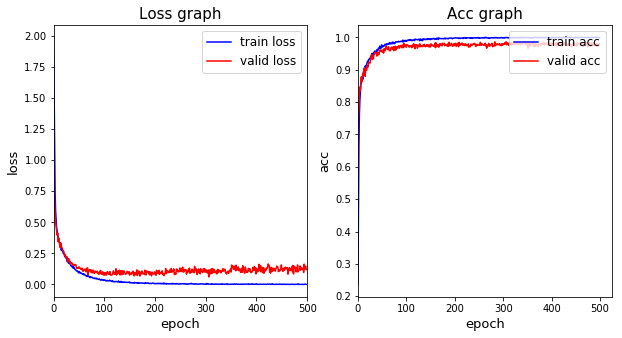

In [51]:
# UWave
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

#### with confusion matrix

In [52]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [53]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

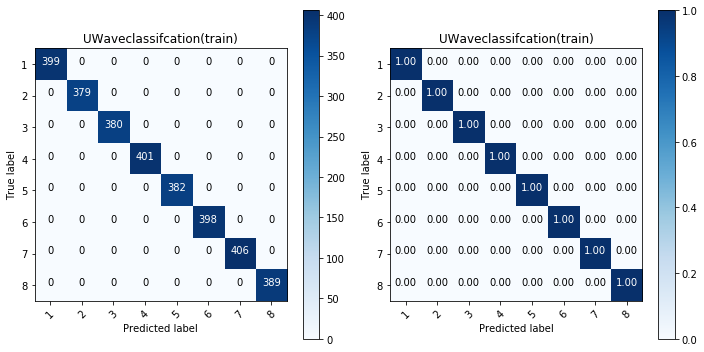

In [54]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0, is_dropout =False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

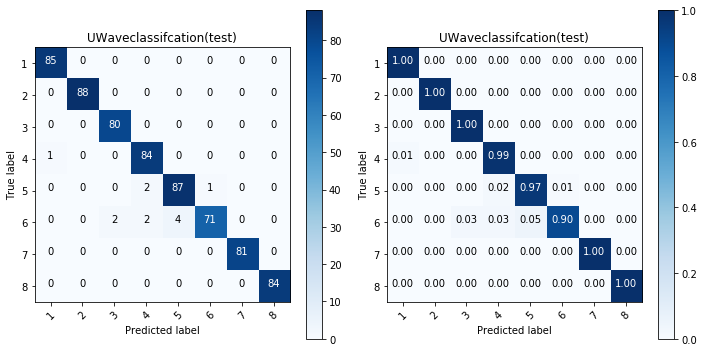

In [56]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0, is_dropout =False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# Another dataset

## FaceDetection
Classes: Face (Class 1) or Scramble (Class 0)

Dataset Link: http://www.timeseriesclassification.com/description.php?Dataset=FaceDetection

In [0]:
trn = arff.loadarff('./data/FaceDetection/FaceDetection_TRAIN.arff')
tst = arff.loadarff('./data/FaceDetection/FaceDetection_TEST.arff')

In [0]:
trainx, trainy  = trn[0]['SERIES'], trn[0]['class']
testx, testy  = tst[0]['SERIES'], tst[0]['class']

In [0]:
def reshapingFaceDetection(X, Y):
    reshapedX = []
    sample = []
    for i in range(len(X)):
        for j in range(len(X[i])):
            sample.append(X[i][j].tolist())
        reshapedX.append(sample)
        sample = []
    reshapedX = np.array(reshapedX, dtype=np.float64)
    
    reshapedY = []
    reshapedY = np.array(Y, dtype=np.int64)
    reshapedY = reshapedY.reshape(reshapedY.shape[0],1)

    return reshapedX, reshapedY    

In [0]:
trainx, trainy = reshapingFaceDetection(trainx, trainy)
testx, testy = reshapingFaceDetection(testx, testy)

In [0]:
print('train: ', trainx.shape, trainy.shape)
print('test: ', testx.shape, testy.shape)

train:  (5890, 144, 62) (5890, 1)
test:  (3524, 144, 62) (3524, 1)


In [0]:
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

batch size:16
(5890, 144, 62) (5890, 1)
(3524, 144, 62) (3524, 1)


In [0]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (5890, 2)
y test shape: (3524, 2)


In [0]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train
validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]
testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]
print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(5890, 1, 144, 62)
trainY shape:(5890, 2)
validX shape:(1762, 1, 144, 62)
validY shape:(1762, 2)
testX shape:(1762, 1, 144, 62)
testY shape:(1762, 2)


In [0]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]
print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 144
input_channel 62


In [0]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-4

In [0]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

In [0]:
nb_classes =trainY.shape[1]
print (nb_classes)

2


In [0]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
#MC_dropout_model =CNN_MC_dropout_input_turnoff(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

#MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [0]:

print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.dense1)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 144, 62), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 144, 64), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 71, 64), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 71, 64), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 71, 64), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 71, 64), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 71, 128), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 34, 128), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 34, 128), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 34, 128), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 34, 128), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 34, 256), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", shape=(?, 1, 16, 25

In [0]:
data_name = 'FaceDetection'

In [0]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_standardized_dropout_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16


In [0]:
keep_prob =0.5

In [0]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))

INFO:tensorflow:./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/1.ckpt
  training loss:	0.916426
  training acc:	0.506
  validation loss:	0.711479
  validation acc:	0.494
INFO:tensorflow:./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/2.ckpt
  training loss:	0.705360
  training acc:	0.499
  validation loss:	0.693235
  validation acc:	0.512
INFO:tensorflow:./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/FaceDetection/FaceDetection_CNN_MCdro

In [0]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

save ./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/loss_graph.png
save ./model/FaceDetection/FaceDetection_CNN_MCdropout_basic_standardized_dropout_0.0001_16/acc_graph.png


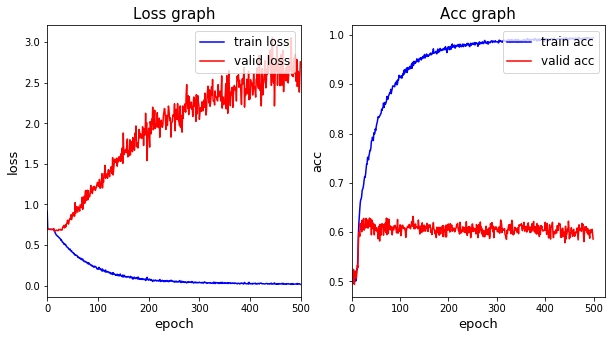

In [0]:
# FaceDetection
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [0]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

## StarlithCurves & EthanolLevel

In [236]:
datanames = ['StarLightCurves', 'EthanolLevel']
data_name = datanames[1]

In [237]:
train = arff.loadarff('./data/'+data_name+'/'+data_name+'_TRAIN.arff')
test = arff.loadarff('./data/'+data_name+'/'+data_name+'_TEST.arff')

In [238]:
train = pd.DataFrame(train[0]).values
test = pd.DataFrame(test[0]).values

In [239]:
trainx, trainy = train[:,0:-1], train[:,-1]
testx, testy = test[:,0:-1], test[:,-1]

In [240]:
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

(504, 1751) (504,)
(500, 1751) (500,)


In [241]:
trainx, testx = np.array(trainx, dtype=np.float64), np.array(testx, dtype=np.float64)
trainy, testy = np.array(trainy, dtype=np.int64), np.array(testy, dtype=np.int64)

In [242]:
trainx, testx = trainx.reshape(trainx.shape[0], trainx.shape[1], 1), testx.reshape(testx.shape[0], testx.shape[1], 1)
trainy, testy = trainy.reshape(trainy.shape[0], 1), testy.reshape(testy.shape[0], 1)

In [243]:
dataX = np.vstack([trainx, testx])
dataY = np.vstack([trainy, testy])
trainx, testx, trainy, testy = train_test_split(dataX, dataY, test_size=0.3, random_state=42)

In [244]:
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

(702, 1751, 1) (702, 1)
(302, 1751, 1) (302, 1)


In [245]:
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))

batch size:16


In [246]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (702, 4)
y test shape: (302, 4)


In [247]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train
validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]
testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]
print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(702, 1, 1751, 1)
trainY shape:(702, 4)
validX shape:(151, 1, 1751, 1)
validY shape:(151, 4)
testX shape:(151, 1, 1751, 1)
testY shape:(151, 4)


In [248]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]
print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 1751
input_channel 1


### training condition

In [264]:
t_loss=[]
t_acc=[]
v_loss=[]
v_acc=[]
val_freq = 1
save_freq = 1

std= 0.01
num_epochs= 2000
l_rate = 1e-5

In [265]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

In [266]:
nb_classes =trainY.shape[1]
print (nb_classes)

4


In [267]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()

In [268]:
MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [269]:
# print (MC_dropout_model.input)

# print ('[layer1] - MC dropout')
# print (MC_dropout_model.conv1)
# print (MC_dropout_model.pooling1)
# print (MC_dropout_model.batch1)
# print (MC_dropout_model.relu1)
# print (MC_dropout_model.dropout1)
# print ('[layer2] - MC dropout')
# print (MC_dropout_model.conv2)
# print (MC_dropout_model.pooling2)
# print (MC_dropout_model.batch2)
# print (MC_dropout_model.relu2)
# print (MC_dropout_model.dropout2)
# print ('[layer3]')
# print (MC_dropout_model.conv3)
# print (MC_dropout_model.pooling3)
# print (MC_dropout_model.batch3)
# print (MC_dropout_model.relu3)

# print ('[layer4]')
# print (MC_dropout_model.flatten)
# print (MC_dropout_model.dense1)
# print (MC_dropout_model.logits)

In [270]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_standardized_dropout_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16


In [271]:
keep_prob =0.5

In [272]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1.ckpt
  training loss:	1.445676
  training acc:	0.227
  validation loss:	1.419676
  validation acc:	0.319
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/2.ckpt
  training loss:	1.422586
  training acc:	0.253
  validation loss:	1.416565
  validation acc:	0.271
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standa

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/23.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/23.ckpt
  training loss:	1.387148
  training acc:	0.273
  validation loss:	1.412525
  validation acc:	0.215
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/24.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/24.ckpt
  training loss:	1.379574
  training acc:	0.279
  validation loss:	1.414188
  validation acc:	0.243
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/25.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_s

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/45.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/45.ckpt
  training loss:	1.385000
  training acc:	0.288
  validation loss:	1.378525
  validation acc:	0.347
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/46.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/46.ckpt
  training loss:	1.387757
  training acc:	0.251
  validation loss:	1.386584
  validation acc:	0.215
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/47.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_s

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/67.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/67.ckpt
  training loss:	1.379069
  training acc:	0.301
  validation loss:	1.393736
  validation acc:	0.257
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/68.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/68.ckpt
  training loss:	1.381641
  training acc:	0.273
  validation loss:	1.387335
  validation acc:	0.264
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/69.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_s

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/89.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/89.ckpt
  training loss:	1.374265
  training acc:	0.317
  validation loss:	1.400664
  validation acc:	0.257
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/90.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/90.ckpt
  training loss:	1.375533
  training acc:	0.273
  validation loss:	1.372845
  validation acc:	0.306
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/91.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_s

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/111.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/111.ckpt
  training loss:	1.370659
  training acc:	0.297
  validation loss:	1.395808
  validation acc:	0.236
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/112.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/112.ckpt
  training loss:	1.370435
  training acc:	0.298
  validation loss:	1.395407
  validation acc:	0.271
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/113.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/133.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/133.ckpt
  training loss:	1.356861
  training acc:	0.310
  validation loss:	1.385440
  validation acc:	0.299
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/134.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/134.ckpt
  training loss:	1.363517
  training acc:	0.311
  validation loss:	1.378388
  validation acc:	0.333
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/135.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

  training loss:	1.360493
  training acc:	0.310
  validation loss:	1.366225
  validation acc:	0.306
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/155.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/155.ckpt
  training loss:	1.355719
  training acc:	0.317
  validation loss:	1.390440
  validation acc:	0.333
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/156.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/156.ckpt
  training loss:	1.365200
  training acc:	0.311
  validation loss:	1.390223
  validation acc:	0.264
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/157.ckpt is not in all_model_checkpoin

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/176.ckpt
  training loss:	1.347998
  training acc:	0.344
  validation loss:	1.383136
  validation acc:	0.264
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/177.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/177.ckpt
  training loss:	1.336022
  training acc:	0.350
  validation loss:	1.357935
  validation acc:	0.361
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/178.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/178.ckpt
  training loss:	1.349111
  training acc:	0.324
  validation loss:	1.373344
  validation acc:	0.271
INFO:tensorflow:./model/

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/198.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/198.ckpt
  training loss:	1.339664
  training acc:	0.326
  validation loss:	1.308178
  validation acc:	0.396
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/199.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/199.ckpt
  training loss:	1.333706
  training acc:	0.355
  validation loss:	1.351299
  validation acc:	0.340
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/200.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/220.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/220.ckpt
  training loss:	1.335496
  training acc:	0.333
  validation loss:	1.355653
  validation acc:	0.326
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/221.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/221.ckpt
  training loss:	1.326084
  training acc:	0.381
  validation loss:	1.292656
  validation acc:	0.424
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/222.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/242.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/242.ckpt
  training loss:	1.291756
  training acc:	0.397
  validation loss:	1.333173
  validation acc:	0.368
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/243.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/243.ckpt
  training loss:	1.317937
  training acc:	0.372
  validation loss:	1.319678
  validation acc:	0.354
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/244.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/264.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/264.ckpt
  training loss:	1.303966
  training acc:	0.387
  validation loss:	1.323916
  validation acc:	0.340
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/265.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/265.ckpt
  training loss:	1.296860
  training acc:	0.376
  validation loss:	1.343785
  validation acc:	0.340
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/266.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/286.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/286.ckpt
  training loss:	1.280737
  training acc:	0.401
  validation loss:	1.337861
  validation acc:	0.326
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/287.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/287.ckpt
  training loss:	1.262862
  training acc:	0.398
  validation loss:	1.268328
  validation acc:	0.396
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/288.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/308.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/308.ckpt
  training loss:	1.282099
  training acc:	0.397
  validation loss:	1.261856
  validation acc:	0.417
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/309.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/309.ckpt
  training loss:	1.271259
  training acc:	0.406
  validation loss:	1.258193
  validation acc:	0.444
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/310.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/330.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/330.ckpt
  training loss:	1.260363
  training acc:	0.416
  validation loss:	1.251941
  validation acc:	0.403
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/331.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/331.ckpt
  training loss:	1.253635
  training acc:	0.420
  validation loss:	1.252302
  validation acc:	0.375
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/332.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/352.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/352.ckpt
  training loss:	1.225514
  training acc:	0.427
  validation loss:	1.264736
  validation acc:	0.396
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/353.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/353.ckpt
  training loss:	1.243039
  training acc:	0.423
  validation loss:	1.275287
  validation acc:	0.417
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/354.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/374.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/374.ckpt
  training loss:	1.212392
  training acc:	0.432
  validation loss:	1.204910
  validation acc:	0.444
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/375.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/375.ckpt
  training loss:	1.231000
  training acc:	0.442
  validation loss:	1.249384
  validation acc:	0.375
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/376.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/396.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/396.ckpt
  training loss:	1.210264
  training acc:	0.426
  validation loss:	1.191225
  validation acc:	0.472
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/397.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/397.ckpt
  training loss:	1.202598
  training acc:	0.462
  validation loss:	1.203436
  validation acc:	0.444
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/398.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/418.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/418.ckpt
  training loss:	1.200327
  training acc:	0.440
  validation loss:	1.233982
  validation acc:	0.424
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/419.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/419.ckpt
  training loss:	1.194186
  training acc:	0.472
  validation loss:	1.180093
  validation acc:	0.465
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/420.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/440.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/440.ckpt
  training loss:	1.178830
  training acc:	0.462
  validation loss:	1.191747
  validation acc:	0.444
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/441.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/441.ckpt
  training loss:	1.193976
  training acc:	0.452
  validation loss:	1.110126
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/442.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/462.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/462.ckpt
  training loss:	1.169136
  training acc:	0.494
  validation loss:	1.144747
  validation acc:	0.507
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/463.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/463.ckpt
  training loss:	1.146209
  training acc:	0.472
  validation loss:	1.245200
  validation acc:	0.410
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/464.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/484.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/484.ckpt
  training loss:	1.176002
  training acc:	0.474
  validation loss:	1.202709
  validation acc:	0.410
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/485.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/485.ckpt
  training loss:	1.129373
  training acc:	0.493
  validation loss:	1.163992
  validation acc:	0.472
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/486.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/506.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/506.ckpt
  training loss:	1.168591
  training acc:	0.490
  validation loss:	1.099765
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/507.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/507.ckpt
  training loss:	1.121607
  training acc:	0.472
  validation loss:	1.079005
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/508.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/528.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/528.ckpt
  training loss:	1.141554
  training acc:	0.481
  validation loss:	1.180722
  validation acc:	0.472
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/529.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/529.ckpt
  training loss:	1.124235
  training acc:	0.475
  validation loss:	1.131716
  validation acc:	0.431
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/530.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/550.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/550.ckpt
  training loss:	1.108297
  training acc:	0.500
  validation loss:	1.060832
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/551.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/551.ckpt
  training loss:	1.133006
  training acc:	0.475
  validation loss:	1.079354
  validation acc:	0.458
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/552.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/572.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/572.ckpt
  training loss:	1.114607
  training acc:	0.499
  validation loss:	1.205365
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/573.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/573.ckpt
  training loss:	1.148380
  training acc:	0.467
  validation loss:	1.075995
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/574.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/594.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/594.ckpt
  training loss:	1.117199
  training acc:	0.469
  validation loss:	1.136250
  validation acc:	0.438
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/595.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/595.ckpt
  training loss:	1.093798
  training acc:	0.517
  validation loss:	1.094453
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/596.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/616.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/616.ckpt
  training loss:	1.126270
  training acc:	0.481
  validation loss:	1.153269
  validation acc:	0.465
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/617.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/617.ckpt
  training loss:	1.090819
  training acc:	0.522
  validation loss:	1.115729
  validation acc:	0.500
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/618.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/638.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/638.ckpt
  training loss:	1.114639
  training acc:	0.500
  validation loss:	1.142003
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/639.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/639.ckpt
  training loss:	1.084457
  training acc:	0.509
  validation loss:	1.087912
  validation acc:	0.472
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/640.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/660.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/660.ckpt
  training loss:	1.081126
  training acc:	0.528
  validation loss:	1.061115
  validation acc:	0.507
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/661.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/661.ckpt
  training loss:	1.106326
  training acc:	0.512
  validation loss:	1.085885
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/662.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/682.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/682.ckpt
  training loss:	1.056500
  training acc:	0.525
  validation loss:	1.104005
  validation acc:	0.438
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/683.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/683.ckpt
  training loss:	1.055598
  training acc:	0.519
  validation loss:	1.121969
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/684.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/704.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/704.ckpt
  training loss:	1.074947
  training acc:	0.485
  validation loss:	1.100941
  validation acc:	0.479
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/705.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/705.ckpt
  training loss:	1.101747
  training acc:	0.504
  validation loss:	1.146506
  validation acc:	0.479
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/706.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/726.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/726.ckpt
  training loss:	1.061575
  training acc:	0.493
  validation loss:	1.039159
  validation acc:	0.500
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/727.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/727.ckpt
  training loss:	1.067005
  training acc:	0.517
  validation loss:	1.128396
  validation acc:	0.465
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/728.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/748.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/748.ckpt
  training loss:	1.058381
  training acc:	0.532
  validation loss:	1.052806
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/749.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/749.ckpt
  training loss:	1.061024
  training acc:	0.539
  validation loss:	1.056220
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/750.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/770.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/770.ckpt
  training loss:	1.054310
  training acc:	0.525
  validation loss:	1.098739
  validation acc:	0.500
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/771.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/771.ckpt
  training loss:	1.059530
  training acc:	0.525
  validation loss:	1.077211
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/772.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/792.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/792.ckpt
  training loss:	1.011783
  training acc:	0.562
  validation loss:	1.067927
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/793.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/793.ckpt
  training loss:	1.039012
  training acc:	0.549
  validation loss:	1.078177
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/794.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/814.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/814.ckpt
  training loss:	1.041969
  training acc:	0.533
  validation loss:	1.078530
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/815.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/815.ckpt
  training loss:	1.021730
  training acc:	0.545
  validation loss:	0.972037
  validation acc:	0.618
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/816.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/836.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/836.ckpt
  training loss:	1.035323
  training acc:	0.532
  validation loss:	1.116845
  validation acc:	0.472
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/837.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/837.ckpt
  training loss:	1.022274
  training acc:	0.531
  validation loss:	1.107171
  validation acc:	0.458
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/838.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/858.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/858.ckpt
  training loss:	1.008119
  training acc:	0.551
  validation loss:	1.093174
  validation acc:	0.479
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/859.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/859.ckpt
  training loss:	1.024801
  training acc:	0.523
  validation loss:	1.044843
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/860.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/880.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/880.ckpt
  training loss:	1.004530
  training acc:	0.542
  validation loss:	0.982236
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/881.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/881.ckpt
  training loss:	1.021991
  training acc:	0.557
  validation loss:	1.080831
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/882.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/902.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/902.ckpt
  training loss:	1.036140
  training acc:	0.520
  validation loss:	1.068781
  validation acc:	0.479
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/903.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/903.ckpt
  training loss:	1.038465
  training acc:	0.519
  validation loss:	1.092261
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/904.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/924.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/924.ckpt
  training loss:	1.014783
  training acc:	0.568
  validation loss:	1.061623
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/925.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/925.ckpt
  training loss:	1.008425
  training acc:	0.536
  validation loss:	1.134294
  validation acc:	0.438
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/926.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/946.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/946.ckpt
  training loss:	0.996669
  training acc:	0.560
  validation loss:	1.055574
  validation acc:	0.500
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/947.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/947.ckpt
  training loss:	1.001844
  training acc:	0.535
  validation loss:	1.010651
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/948.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/968.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/968.ckpt
  training loss:	0.966671
  training acc:	0.558
  validation loss:	0.999645
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/969.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/969.ckpt
  training loss:	0.995399
  training acc:	0.551
  validation loss:	1.015121
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/970.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/990.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/990.ckpt
  training loss:	0.996331
  training acc:	0.545
  validation loss:	1.059139
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/991.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/991.ckpt
  training loss:	1.007305
  training acc:	0.570
  validation loss:	1.059758
  validation acc:	0.500
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/992.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_ba

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1012.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1012.ckpt
  training loss:	1.004871
  training acc:	0.570
  validation loss:	0.998041
  validation acc:	0.486
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1013.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1013.ckpt
  training loss:	1.039229
  training acc:	0.522
  validation loss:	1.110188
  validation acc:	0.479
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1014.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1033.ckpt
  training loss:	0.982516
  training acc:	0.542
  validation loss:	1.088371
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1034.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1034.ckpt
  training loss:	0.982718
  training acc:	0.558
  validation loss:	0.999180
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1035.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1035.ckpt
  training loss:	0.986014
  training acc:	0.558
  validation loss:	0.964286
  validation acc:	0.576
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1055.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1055.ckpt
  training loss:	0.995684
  training acc:	0.570
  validation loss:	0.990601
  validation acc:	0.576
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1056.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1056.ckpt
  training loss:	1.003660
  training acc:	0.536
  validation loss:	0.984139
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1057.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1076.ckpt
  training loss:	0.983851
  training acc:	0.568
  validation loss:	0.976665
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1077.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1077.ckpt
  training loss:	0.941865
  training acc:	0.568
  validation loss:	1.010289
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1078.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1078.ckpt
  training loss:	0.973595
  training acc:	0.593
  validation loss:	1.109362
  validation acc:	0.465
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1098.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1098.ckpt
  training loss:	0.975836
  training acc:	0.571
  validation loss:	1.033113
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1099.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1099.ckpt
  training loss:	0.981437
  training acc:	0.586
  validation loss:	1.041443
  validation acc:	0.493
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1100.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1119.ckpt
  training loss:	0.965014
  training acc:	0.570
  validation loss:	1.019235
  validation acc:	0.528
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1120.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1120.ckpt
  training loss:	0.998941
  training acc:	0.541
  validation loss:	1.002284
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1121.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1121.ckpt
  training loss:	0.962750
  training acc:	0.577
  validation loss:	0.983670
  validation acc:	0.583
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1141.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1141.ckpt
  training loss:	0.964333
  training acc:	0.552
  validation loss:	0.955430
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1142.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1142.ckpt
  training loss:	0.953762
  training acc:	0.589
  validation loss:	1.003824
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1143.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1162.ckpt
  training loss:	0.963009
  training acc:	0.555
  validation loss:	1.061295
  validation acc:	0.507
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1163.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1163.ckpt
  training loss:	0.952663
  training acc:	0.551
  validation loss:	0.982932
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1164.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1164.ckpt
  training loss:	0.986910
  training acc:	0.581
  validation loss:	1.096771
  validation acc:	0.479
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1184.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1184.ckpt
  training loss:	0.970108
  training acc:	0.580
  validation loss:	0.980433
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1185.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1185.ckpt
  training loss:	0.966802
  training acc:	0.545
  validation loss:	1.010145
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1186.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1205.ckpt
  training loss:	0.954993
  training acc:	0.592
  validation loss:	1.074999
  validation acc:	0.486
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1206.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1206.ckpt
  training loss:	0.941637
  training acc:	0.571
  validation loss:	1.062431
  validation acc:	0.507
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1207.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1207.ckpt
  training loss:	0.932270
  training acc:	0.605
  validation loss:	0.950952
  validation acc:	0.521
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1227.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1227.ckpt
  training loss:	0.973173
  training acc:	0.561
  validation loss:	1.014819
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1228.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1228.ckpt
  training loss:	0.972150
  training acc:	0.567
  validation loss:	1.050531
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1229.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1248.ckpt
  training loss:	0.945948
  training acc:	0.565
  validation loss:	0.994512
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1249.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1249.ckpt
  training loss:	0.944975
  training acc:	0.580
  validation loss:	0.979814
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1250.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1250.ckpt
  training loss:	0.968974
  training acc:	0.573
  validation loss:	1.054040
  validation acc:	0.500
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1270.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1270.ckpt
  training loss:	0.929233
  training acc:	0.577
  validation loss:	1.065777
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1271.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1271.ckpt
  training loss:	0.940453
  training acc:	0.565
  validation loss:	1.032161
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1272.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1291.ckpt
  training loss:	0.976476
  training acc:	0.567
  validation loss:	0.977925
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1292.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1292.ckpt
  training loss:	0.953619
  training acc:	0.551
  validation loss:	1.025874
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1293.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1293.ckpt
  training loss:	0.926195
  training acc:	0.600
  validation loss:	0.981467
  validation acc:	0.556
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1313.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1313.ckpt
  training loss:	0.951955
  training acc:	0.578
  validation loss:	1.009950
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1314.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1314.ckpt
  training loss:	0.963698
  training acc:	0.548
  validation loss:	1.104604
  validation acc:	0.528
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1315.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1334.ckpt
  training loss:	0.910185
  training acc:	0.603
  validation loss:	1.025941
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1335.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1335.ckpt
  training loss:	0.929431
  training acc:	0.570
  validation loss:	1.006278
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1336.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1336.ckpt
  training loss:	0.934577
  training acc:	0.567
  validation loss:	0.970852
  validation acc:	0.542
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1356.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1356.ckpt
  training loss:	0.947891
  training acc:	0.564
  validation loss:	1.008048
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1357.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1357.ckpt
  training loss:	0.925949
  training acc:	0.573
  validation loss:	1.033298
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1358.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1377.ckpt
  training loss:	0.942175
  training acc:	0.580
  validation loss:	0.945131
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1378.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1378.ckpt
  training loss:	0.936590
  training acc:	0.603
  validation loss:	1.028749
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1379.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1379.ckpt
  training loss:	0.928903
  training acc:	0.568
  validation loss:	0.899366
  validation acc:	0.576
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1399.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1399.ckpt
  training loss:	0.928350
  training acc:	0.589
  validation loss:	0.959566
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1400.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1400.ckpt
  training loss:	0.914277
  training acc:	0.609
  validation loss:	1.024655
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1401.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1420.ckpt
  training loss:	0.920132
  training acc:	0.606
  validation loss:	0.980384
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1421.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1421.ckpt
  training loss:	0.937889
  training acc:	0.577
  validation loss:	0.884508
  validation acc:	0.639
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1422.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1422.ckpt
  training loss:	0.929812
  training acc:	0.610
  validation loss:	0.927931
  validation acc:	0.576
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1442.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1442.ckpt
  training loss:	0.940820
  training acc:	0.565
  validation loss:	0.995001
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1443.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1443.ckpt
  training loss:	0.942095
  training acc:	0.583
  validation loss:	0.961379
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1444.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1463.ckpt
  training loss:	0.883430
  training acc:	0.603
  validation loss:	0.999384
  validation acc:	0.576
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1464.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1464.ckpt
  training loss:	0.938868
  training acc:	0.573
  validation loss:	1.050450
  validation acc:	0.528
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1465.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1465.ckpt
  training loss:	0.926890
  training acc:	0.594
  validation loss:	0.985730
  validation acc:	0.569
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1485.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1485.ckpt
  training loss:	0.904971
  training acc:	0.584
  validation loss:	1.010784
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1486.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1486.ckpt
  training loss:	0.919864
  training acc:	0.608
  validation loss:	0.972272
  validation acc:	0.521
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1487.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1506.ckpt
  training loss:	0.933016
  training acc:	0.583
  validation loss:	0.983314
  validation acc:	0.597
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1507.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1507.ckpt
  training loss:	0.901833
  training acc:	0.599
  validation loss:	0.991610
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1508.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1508.ckpt
  training loss:	0.896722
  training acc:	0.596
  validation loss:	1.030573
  validation acc:	0.535
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1528.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1528.ckpt
  training loss:	0.883670
  training acc:	0.610
  validation loss:	0.973914
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1529.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1529.ckpt
  training loss:	0.925969
  training acc:	0.600
  validation loss:	0.969454
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1530.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1549.ckpt
  training loss:	0.877842
  training acc:	0.618
  validation loss:	0.944157
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1550.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1550.ckpt
  training loss:	0.877473
  training acc:	0.606
  validation loss:	0.975072
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1551.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1551.ckpt
  training loss:	0.885056
  training acc:	0.618
  validation loss:	0.907574
  validation acc:	0.597
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1571.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1571.ckpt
  training loss:	0.902058
  training acc:	0.594
  validation loss:	0.926785
  validation acc:	0.597
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1572.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1572.ckpt
  training loss:	0.887715
  training acc:	0.612
  validation loss:	0.951795
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1573.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1592.ckpt
  training loss:	0.898762
  training acc:	0.606
  validation loss:	1.033788
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1593.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1593.ckpt
  training loss:	0.861992
  training acc:	0.628
  validation loss:	0.951683
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1594.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1594.ckpt
  training loss:	0.909222
  training acc:	0.596
  validation loss:	1.028077
  validation acc:	0.562
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1614.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1614.ckpt
  training loss:	0.894234
  training acc:	0.587
  validation loss:	0.947050
  validation acc:	0.576
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1615.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1615.ckpt
  training loss:	0.886581
  training acc:	0.597
  validation loss:	0.977424
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1616.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1635.ckpt
  training loss:	0.902634
  training acc:	0.583
  validation loss:	0.932150
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1636.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1636.ckpt
  training loss:	0.908684
  training acc:	0.590
  validation loss:	0.983665
  validation acc:	0.590
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1637.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1637.ckpt
  training loss:	0.883147
  training acc:	0.599
  validation loss:	0.957506
  validation acc:	0.535
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1657.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1657.ckpt
  training loss:	0.892175
  training acc:	0.594
  validation loss:	0.920116
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1658.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1658.ckpt
  training loss:	0.848105
  training acc:	0.628
  validation loss:	0.903030
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1659.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1678.ckpt
  training loss:	0.923395
  training acc:	0.596
  validation loss:	1.049116
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1679.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1679.ckpt
  training loss:	0.859985
  training acc:	0.632
  validation loss:	1.043324
  validation acc:	0.556
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1680.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1680.ckpt
  training loss:	0.873316
  training acc:	0.621
  validation loss:	0.946255
  validation acc:	0.507
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1700.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1700.ckpt
  training loss:	0.912131
  training acc:	0.574
  validation loss:	0.941321
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1701.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1701.ckpt
  training loss:	0.878124
  training acc:	0.624
  validation loss:	0.957449
  validation acc:	0.514
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1702.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1721.ckpt
  training loss:	0.882603
  training acc:	0.608
  validation loss:	0.903540
  validation acc:	0.625
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1722.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1722.ckpt
  training loss:	0.861078
  training acc:	0.635
  validation loss:	0.871128
  validation acc:	0.604
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1723.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1723.ckpt
  training loss:	0.877988
  training acc:	0.605
  validation loss:	0.989447
  validation acc:	0.576
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1743.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1743.ckpt
  training loss:	0.859294
  training acc:	0.621
  validation loss:	0.802163
  validation acc:	0.625
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1744.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1744.ckpt
  training loss:	0.897231
  training acc:	0.583
  validation loss:	0.951611
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1745.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1764.ckpt
  training loss:	0.903468
  training acc:	0.596
  validation loss:	0.953827
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1765.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1765.ckpt
  training loss:	0.880721
  training acc:	0.610
  validation loss:	0.947499
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1766.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1766.ckpt
  training loss:	0.841534
  training acc:	0.618
  validation loss:	0.924043
  validation acc:	0.556
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1786.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1786.ckpt
  training loss:	0.866607
  training acc:	0.612
  validation loss:	0.913459
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1787.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1787.ckpt
  training loss:	0.830358
  training acc:	0.621
  validation loss:	0.865272
  validation acc:	0.618
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1788.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1807.ckpt
  training loss:	0.863373
  training acc:	0.583
  validation loss:	0.805036
  validation acc:	0.708
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1808.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1808.ckpt
  training loss:	0.861407
  training acc:	0.641
  validation loss:	0.943712
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1809.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1809.ckpt
  training loss:	0.892894
  training acc:	0.613
  validation loss:	1.011972
  validation acc:	0.556
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1829.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1829.ckpt
  training loss:	0.849594
  training acc:	0.622
  validation loss:	0.898174
  validation acc:	0.597
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1830.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1830.ckpt
  training loss:	0.828504
  training acc:	0.640
  validation loss:	0.934368
  validation acc:	0.611
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1831.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1850.ckpt
  training loss:	0.848721
  training acc:	0.621
  validation loss:	0.981027
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1851.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1851.ckpt
  training loss:	0.876309
  training acc:	0.610
  validation loss:	0.987796
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1852.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1852.ckpt
  training loss:	0.854275
  training acc:	0.618
  validation loss:	0.948385
  validation acc:	0.597
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1872.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1872.ckpt
  training loss:	0.874814
  training acc:	0.634
  validation loss:	0.901985
  validation acc:	0.604
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1873.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1873.ckpt
  training loss:	0.843520
  training acc:	0.635
  validation loss:	0.952261
  validation acc:	0.562
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1874.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1893.ckpt
  training loss:	0.880655
  training acc:	0.624
  validation loss:	0.936442
  validation acc:	0.542
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1894.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1894.ckpt
  training loss:	0.845237
  training acc:	0.632
  validation loss:	0.901151
  validation acc:	0.625
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1895.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1895.ckpt
  training loss:	0.840782
  training acc:	0.653
  validation loss:	0.808612
  validation acc:	0.653
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1915.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1915.ckpt
  training loss:	0.861230
  training acc:	0.621
  validation loss:	0.960479
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1916.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1916.ckpt
  training loss:	0.891971
  training acc:	0.594
  validation loss:	0.911896
  validation acc:	0.583
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1917.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1936.ckpt
  training loss:	0.865271
  training acc:	0.628
  validation loss:	0.961384
  validation acc:	0.549
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1937.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1937.ckpt
  training loss:	0.856387
  training acc:	0.603
  validation loss:	0.921531
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1938.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1938.ckpt
  training loss:	0.824999
  training acc:	0.631
  validation loss:	0.927438
  validation acc:	0.583
INFO:tensorflow:./m

INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1958.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1958.ckpt
  training loss:	0.839367
  training acc:	0.624
  validation loss:	1.001403
  validation acc:	0.535
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1959.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1959.ckpt
  training loss:	0.805990
  training acc:	0.644
  validation loss:	0.887069
  validation acc:	0.604
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1960.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropo

Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1979.ckpt
  training loss:	0.817218
  training acc:	0.661
  validation loss:	0.919439
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1980.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1980.ckpt
  training loss:	0.861452
  training acc:	0.608
  validation loss:	0.962984
  validation acc:	0.569
INFO:tensorflow:./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1981.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/1981.ckpt
  training loss:	0.852689
  training acc:	0.644
  validation loss:	0.985009
  validation acc:	0.514
INFO:tensorflow:./m

In [273]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

In [274]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/loss_graph.png
save ./model/EthanolLevel/EthanolLevel_CNN_MCdropout_basic_standardized_dropout_1e-05_16/acc_graph.png


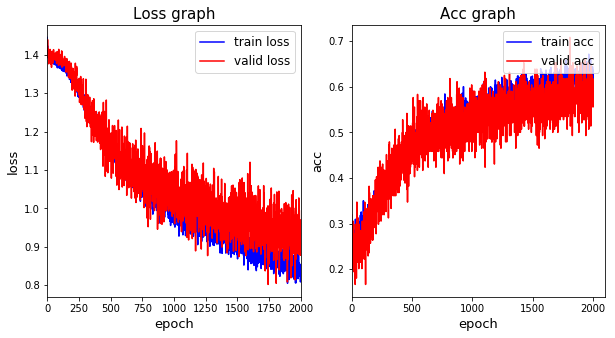

In [275]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [276]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

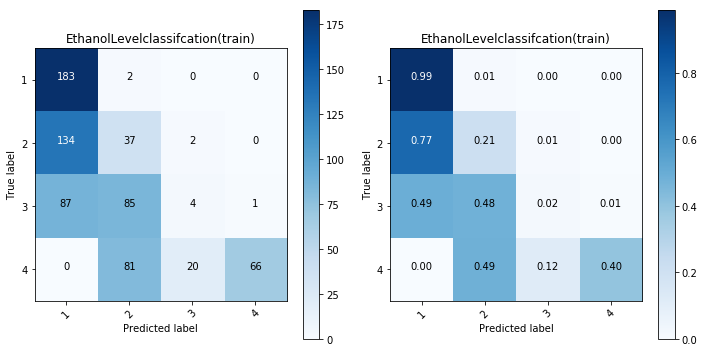

In [277]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0, is_dropout =False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

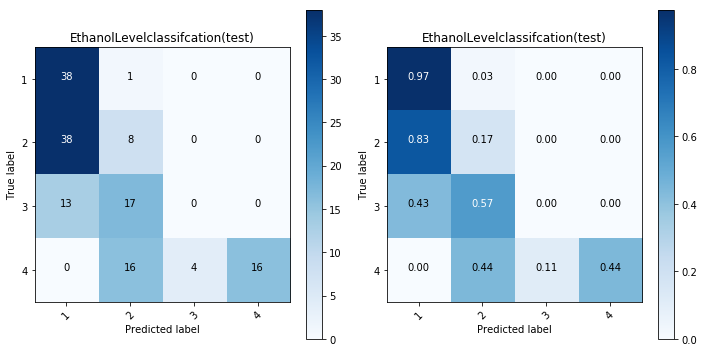

In [278]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0, is_dropout =False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')